In [9]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/bodyfat-dataset')
if iskaggle:
    !pip install -Uqq fastai icrawler
else:
    path = Path('bodyfat-dataset')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [10]:
import torch, numpy as np, pandas as pd

df = pd.read_csv(path/'guessmybf_dataset.csv')

df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,title,url,meanPrediction,medianPrediction,bfPredictions,image_1,image_2,image_3,image_4,image_5
0,Leanest ive ever been. Never seen veins like t...,https://www.reddit.com/gallery/1b6k5jh,8.00,8.0,[8],https://preview.redd.it/leanest-ive-ever-been-...,https://preview.redd.it/leanest-ive-ever-been-...,https://preview.redd.it/leanest-ive-ever-been-...,https://preview.redd.it/leanest-ive-ever-been-...,NaN
1,Let me know. 78kg :),https://i.redd.it/4occeq9wdd2c1.jpg,9.80,10.0,"[9, 10, 10, 9, 11]",https://i.redd.it/4occeq9wdd2c1.jpg,NaN,NaN,NaN,NaN
2,What is my bf% I believe it’s around 13-14%,https://i.redd.it/lvfmowq0zhh91.jpg,14.33,13.5,"[13, 19, 14, 14, 13, 13]",https://i.redd.it/lvfmowq0zhh91.jpg,NaN,NaN,NaN,NaN
3,"25F | 4'11"" | 107 lbs",https://www.reddit.com/gallery/1e30z2f,23.33,24.0,"[20, 26, 24]",https://preview.redd.it/25f-411-107-lbs-v0-4lm...,https://preview.redd.it/25f-411-107-lbs-v0-huc...,NaN,NaN,NaN
4,Bodyfat?,https://www.reddit.com/gallery/1ktwao9,17.80,18.0,"[18, 16, 18, 15, 22]",https://preview.redd.it/8ekhv0d4xl2f1.jpg?widt...,https://preview.redd.it/rwkt50d4xl2f1.jpg?widt...,https://preview.redd.it/vau412d4xl2f1.jpg?widt...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
801,[GMBF] 6'1 220LBS Any estimates appreciated!,https://i.redd.it/z543jfquva731.jpg,12.00,12.0,[12],https://i.redd.it/z543jfquva731.jpg,NaN,NaN,NaN,NaN
802,"[GMBF] (M/22/6'2""/195lbs)",https://i.imgur.com/PY44dK5.jpg,10.50,10.5,"[11, 9, 10, 12]",https://i.imgur.com/PY44dK5.jpg,NaN,NaN,NaN,NaN
803,[GMBF] M/26/6'1/191lbs - down from 245lbs,https://i.imgur.com/pWGT7nV.jpg,15.00,15.0,[15],https://i.imgur.com/pWGT7nV.jpg,NaN,NaN,NaN,NaN
804,[GMBF] (M/26/5’10”/153lbs to 168lbs) What woul...,https://i.redd.it/lc2q2svumrt11.jpg,12.00,12.0,"[10, 14]",https://i.redd.it/lc2q2svumrt11.jpg,NaN,NaN,NaN,NaN


First we must downlaod all the images from our dataframe using simple http fetching. The images are stores as row_image_number.filename

In [11]:
import requests
from tqdm import tqdm

def download_all_images(df, output_dir="images"):
    os.makedirs(output_dir, exist_ok=True)
    image_cols = [f"image_{i}" for i in range(1, 6)]
    
    seen_urls = set()
    image_count = 0

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        for col in image_cols:
            url = row.get(col)
            if isinstance(url, str) and url.startswith("http") and url not in seen_urls:
                try:
                    response = requests.get(url, timeout=10)
                    if response.status_code == 200:
                        file_ext = url.split('.')[-1].split('?')[0]
                        file_name = f"{idx}_{col}.{file_ext}"
                        file_path = os.path.join(output_dir, file_name)
                        with open(file_path, "wb") as f:
                            f.write(response.content)
                        seen_urls.add(url)
                        image_count += 1
                except Exception as e:
                    print(f"Error downloading {url}: {e}")

    print(f"\nDownloaded {image_count} unique images to '{output_dir}/'")

This maps our original dataset, where each row could have up to 5 images, into a dataset where each image has it's own row - and a coresponding body fat %. This prepares the data to be put through our model! 

In [12]:
def create_regression_csv(df, output_csv="image_labels.csv", label_col="meanPrediction", image_prefix="image_", output_dir="images"):
    # Ensure column names are stripped of whitespace
    df.columns = df.columns.str.strip()
    
    image_cols = [col for col in df.columns if col.startswith(image_prefix)]
    records = []

    for idx, row in df.iterrows():
        label = row[label_col]
        for col in image_cols:
            url = row.get(col)
            if isinstance(url, str) and url.startswith("http"):
                ext = url.split('.')[-1].split('?')[0].lower()
                ext = ext if ext in ['jpg', 'jpeg', 'png', 'webp'] else 'jpg'
                filename = f"{idx}_{col}.{ext}"
                records.append({"filename": filename, "target": label})
    
    df_out = pd.DataFrame(records)
    df_out.to_csv(output_csv, index=False)
    print(f"Created {output_csv} with {len(df_out)} labeled images")
    return df_out

Download and map!

In [13]:
#download_all_images(df)  

In [14]:
df_labels = create_regression_csv(df) 

✅ Created image_labels.csv with 1612 labeled images


As we can see, our images have downloaded and are stored in a much more simple dataframe!

In [15]:
df_labels.head()

,filename,target
0,0_image_1.jpg,8.0
1,0_image_2.jpg,8.0
2,0_image_3.jpg,8.0
3,0_image_4.jpg,8.0
4,1_image_1.jpg,9.8


In [16]:
from fastai.vision.all import *

failed = verify_images(get_image_files(Path('images')))
failed.map(Path.unlink)
len(failed)

0

Now lets make the datablock. For augmentations, we'll do all except warp (that might make the phyisquese look too different). We can see some of our datablock's examples with show_batch.

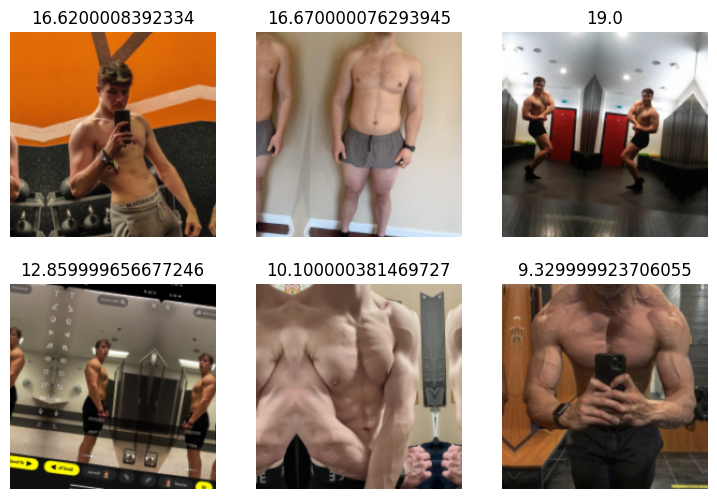

In [17]:
# Create a dictionary: filename -> target
label_dict = dict(zip(df_labels['filename'], df_labels['target']))

path = Path('images')

def get_y_func(fn):
    return label_dict[fn.name]  # fn.name is the filename

item_tfms = Resize(192, method="pad")

batch_tfms = aug_transforms(
    do_flip=True,
    max_rotate=10,
    max_zoom=1.1,
    max_lighting=0.3,
    max_warp=0.,
    p_affine=0.75,
    p_lighting=0.75
)

dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y_func,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

dls = dblock.dataloaders(path, bs=32)

dls.train.show_batch(max_n=6)


Train it!

In [18]:
learn = vision_learner(dls, resnet18, metrics=mse)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,221.759048,201.225479,1.000000,00:30


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,194.144394,192.840439,1.000000,00:29
1,184.993332,175.818207,1.000000,00:29
2,162.849442,131.207352,1.000000,00:30
3,128.562302,78.081612,1.000000,00:29
4,89.093552,47.798523,1.000000,00:29
5,58.559055,25.841013,1.000000,00:29
6,39.819008,20.993525,1.000000,00:29
7,28.747972,19.711956,1.000000,00:29
8,22.580791,18.632248,1.000000,00:29
9,20.297998,17.801714,1.000000,00:28


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

Now we have a working model! For example, it predicts this picture at 13% bodyfat (not so far off in my opinion)

In [29]:
bf,_,probs = learn.predict(PILImage.create('images/248_image_2.jpg'))
print(f"Bodyfat prediction: {probs[0]:.4f}")

Bodyfat prediction: 13.0464
